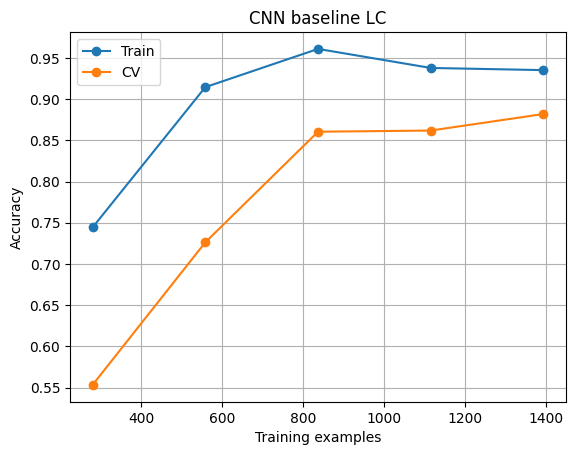

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END clf__batch_size=32, clf__epochs=3, clf__model__dropout_rate=0.3, clf__model__units=64, smote=passthrough; total time=   1.0s
[CV] END clf__batch_size=32, clf__epochs=3, clf__model__dropout_rate=0.3, clf__model__units=64, smote=passthrough; total time=   1.3s
[CV] END clf__batch_size=32, clf__epochs=3, clf__model__dropout_rate=0.3, clf__model__units=64, smote=passthrough; total time=   0.9s
[CV] END clf__batch_size=32, clf__epochs=3, clf__model__dropout_rate=0.3, clf__model__units=128, smote=passthrough; total time=   1.0s
[CV] END clf__batch_size=32, clf__epochs=3, clf__model__dropout_rate=0.3, clf__model__units=128, smote=passthrough; total time=   1.2s
[CV] END clf__batch_size=32, clf__epochs=3, clf__model__dropout_rate=0.3, clf__model__units=128, smote=passthrough; total time=   1.2s
[CV] END clf__batch_size=32, clf__epochs=5, clf__model__dropout_rate=0.3, clf__model__units=128, smote=passthrough; total time=   1.

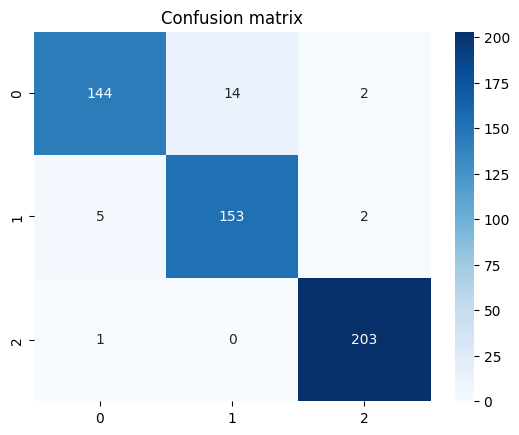

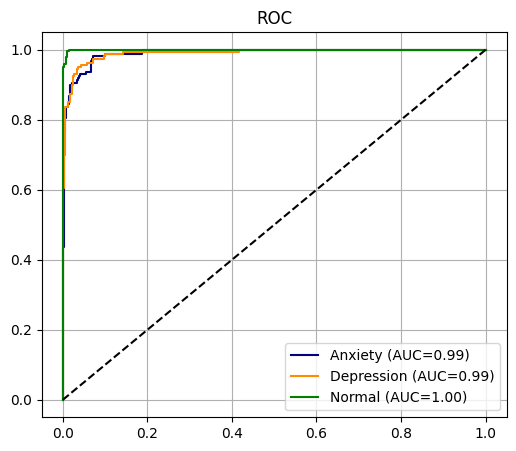

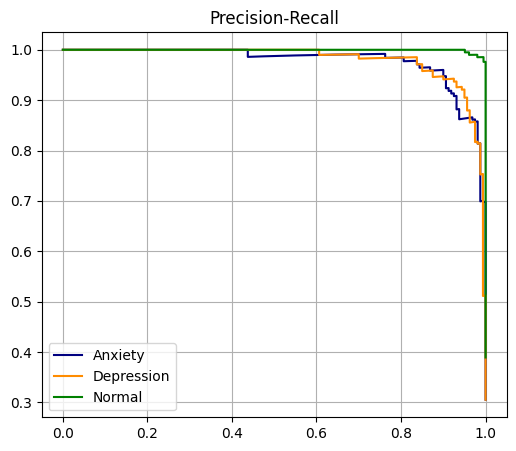

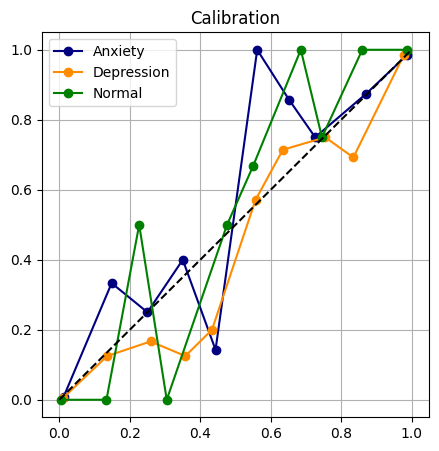


Computing token permutation importances …

Top‑20 tokens by importance:
බය              +0.0177
කනස්සල්ල        +0.0157
කාංසාව          +0.0139
සන්සුන්         +0.0039
විශාදය          +0.0039
වෙනවා           +0.0039
කාංසාවෙන්       +0.0039
තිස්සේ          +0.0038
ජීවිතේ          +0.0038
හොඳ             +0.0037
බිය             +0.0020
බැහැ            +0.0020
දැඩි            +0.0019
ආදරේ            +0.0019
වෙ              +0.0019
දැනෙනවා         +0.0019
මොක             +0.0019
ඉන්නේ           +0.0019
බඩේ             +0.0019
වෙව්ලනවා        +0.0019


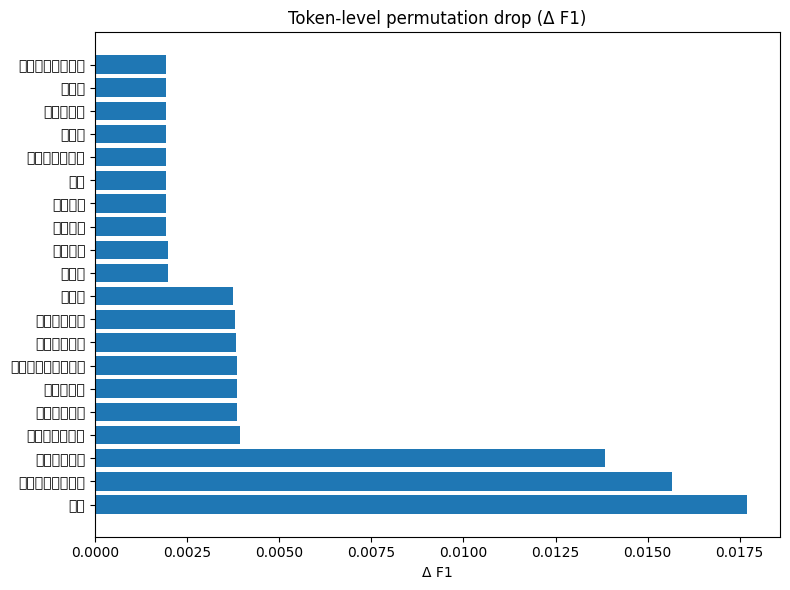

INFO:tensorflow:Assets written to: ram://3637d68edf174410b0773717ff639ddb/assets


INFO:tensorflow:Assets written to: ram://3637d68edf174410b0773717ff639ddb/assets



All artefacts saved.


In [ ]:
# ================================================================
#  Re‑structured CNN pipeline 
# ================================================================
import warnings, pickle, re
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.preprocessing  import LabelEncoder, FunctionTransformer, label_binarize
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.metrics         import (accuracy_score, precision_recall_fscore_support,
                                     roc_auc_score, classification_report, confusion_matrix,
                                     roc_curve, precision_recall_curve, auc)
from sklearn.calibration     import calibration_curve
from imblearn.pipeline       import Pipeline as ImbPipeline          # API symmetry only
from imblearn.over_sampling  import SMOTE
from scikeras.wrappers       import KerasClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense

from lime.lime_text  import LimeTextExplainer
from IPython.display import HTML, display
warnings.filterwarnings("ignore")

# --------------------------- constants ---------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

VOCAB_SIZE = 5_000
MAXLEN     = 100
EMB_DIM    = 50

# ----------------------- Sinhala stemmer ------------------------
COMMON_SUFFIXES = ['වූ','වෙන','වෙයි','වුණ','න්න','නුම්','වී','යේ','යුතු','පුළුවන්',
                   'කරන','කරයි','හු','වරු','ලා','වල්','ගේ','ට','ගෙන්','ළඟ','එක',
                   'යි','ද','ක්','ම','ටයි','තුමා']
def stem_and_join(text: str) -> str:
    parts = []
    for tok in text.split():
        stem = tok
        for suf in COMMON_SUFFIXES:
            if stem.endswith(suf) and len(stem) - len(suf) >= 2:
                stem = stem[:-len(suf)]
                break
        parts.append(stem)
    return " ".join(parts)

# ----------------------- 1. load & encode -----------------------
df = pd.read_csv("../Data/Preprocessed_Manual_Labelled_Dataset.csv")
df["text"] = (df["cleaned_text"].astype(str)
                .str.replace(r"\s+", " ", regex=True)
                .str.strip())

le = LabelEncoder()
df["y"] = le.fit_transform(df["label"])

# ---------------------- 2. split & tokenise ---------------------
X_raw,  y = df["text"], df["y"]
X_tr_raw, X_te_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=.20, stratify=y, random_state=RANDOM_STATE)

X_tr_stem = X_tr_raw.map(stem_and_join)
X_te_stem = X_te_raw.map(stem_and_join)

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_tr_stem)

def tokenise_pad(texts):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=MAXLEN, padding="post")

seq_transformer = FunctionTransformer(tokenise_pad, validate=False)

# ---------------------- 3. CNN builder --------------------------
def build_cnn_model(units=128, dropout_rate=0.5):
    m = Sequential([
        Embedding(VOCAB_SIZE, EMB_DIM, input_length=MAXLEN),
        Conv1D(units, 3, activation="relu"),
        GlobalMaxPooling1D(),
        Dropout(dropout_rate),
        Dense(len(le.classes_), activation="softmax")
    ])
    m.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    return m

# -------------------- 4. baseline learning curve ----------------
def plot_learning_curve(est, X, y, cv=3, title="CNN Learning curve"):
    sizes, tr, cv_ = learning_curve(
        est, X, y, train_sizes=np.linspace(.2,1.0,5),
        scoring="accuracy", cv=cv,
        shuffle=True, random_state=RANDOM_STATE, n_jobs=-1)
    plt.plot(sizes, tr.mean(1),'o-', label="Train")
    plt.plot(sizes, cv_.mean(1),'o-', label="CV")
    plt.title(title); plt.xlabel("Training examples"); plt.ylabel("Accuracy")
    plt.legend(); plt.grid(); plt.show()

baseline_cnn = ImbPipeline([
    ("seqs",  seq_transformer),
    ("smote", "passthrough"),
    ("clf",   KerasClassifier(model=build_cnn_model,
                              model__units=128,
                              model__dropout_rate=.5,
                              epochs=3, batch_size=32,
                              verbose=0, random_state=RANDOM_STATE))
])
plot_learning_curve(baseline_cnn, X_tr_stem, y_train)

# ---------------- 5. Randomised‑search (same API) ---------------
pipe = ImbPipeline([
    ("seqs",  seq_transformer),
    ("smote", "passthrough"),
    ("clf",   KerasClassifier(model=build_cnn_model,
                              verbose=0, random_state=RANDOM_STATE))
])

param_dist = {
    "clf__model__units":        [64,128],
    "clf__model__dropout_rate": [0.3,0.5],
    "clf__epochs":              [3,5],
    "clf__batch_size":          [32,64],
    "smote":                    ["passthrough"]
}

search = RandomizedSearchCV(pipe, param_dist, n_iter=12, cv=3,
                            scoring="f1_weighted", verbose=2,
                            random_state=RANDOM_STATE)
search.fit(X_tr_stem, y_train)
print("Best hyper‑params:", search.best_params_, "\n")
best_cnn = search.best_estimator_

# -------------------- 6. hold‑out evaluation --------------------
y_pred  = best_cnn.predict(X_te_stem)
y_proba = best_cnn.predict_proba(X_te_stem)

acc  = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred,
                                                   average="weighted")
roc  = roc_auc_score(y_test, y_proba,
                     multi_class="ovr", average="weighted")

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1‑score : {f1:.3f}")
print(f"ROC‑AUC  : {roc:.3f}\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix"); plt.show()

# --------------------- 7. LIME explanation ----------------------
explainer = LimeTextExplainer(class_names=le.classes_, split_expression=r"\s+")
idx = 5
exp = explainer.explain_instance(
    X_te_stem.iloc[idx],
    best_cnn.predict_proba,
    num_features=10, num_samples=300)
display(HTML(exp.as_html()))

# ---------------- 8. ROC / PR / calibration curves --------------
y_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
colors = ["navy","darkorange","green"]

plt.figure(figsize=(6,5))
for i,c in enumerate(colors):
    fpr,tpr,_ = roc_curve(y_bin[:,i], y_proba[:,i])
    plt.plot(fpr,tpr,c,label=f"{le.classes_[i]} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--'); plt.title("ROC"); plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(6,5))
for i,c in enumerate(colors):
    p,r,_ = precision_recall_curve(y_bin[:,i], y_proba[:,i])
    plt.plot(r,p,c,label=le.classes_[i])
plt.title("Precision‑Recall"); plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(5,5))
for i,c in enumerate(colors):
    frac, mean = calibration_curve(y_bin[:,i], y_proba[:,i], n_bins=10)
    plt.plot(mean, frac,'o-', color=c, label=le.classes_[i])
plt.plot([0,1],[0,1],'k--'); plt.title("Calibration"); plt.legend(); plt.grid(); plt.show()

# --------------- 9. token‑level permutation importance ----------
def token_perm_drop(pipeline, X_txt, y_true, k=20):
    """Mask each token id across **all** sequences and measure ΔF1."""
    base_f1 = precision_recall_fscore_support(
        y_true, pipeline.predict(X_txt),
        average="weighted")[2]

    seqs  = pipeline.named_steps["seqs"].transform(X_txt)
    drops = []
    clf   = pipeline.named_steps["clf"]

    for tok_id in range(2, VOCAB_SIZE):                 # skip padding & OOV
        masked = seqs.copy()
        masked[masked == tok_id] = 1                    # -> OOV
        f1_new = precision_recall_fscore_support(
                    y_true, clf.predict(masked),
                    average="weighted")[2]
        drops.append((tok_id, base_f1 - f1_new))

    drops  = sorted(drops, key=lambda x: x[1], reverse=True)[:k]
    tokens = [tokenizer.index_word.get(i, f"id{i}") for i,_ in drops]
    vals   = [v for _, v in drops]

    print("\nTop‑{} tokens by importance:".format(k))
    for t, v in zip(tokens, vals):
        print(f"{t:<15s} {v:+.4f}")

    return tokens, vals

print("\nComputing token permutation importances …")
tok, val = token_perm_drop(best_cnn, X_te_stem, y_test, k=20)

plt.figure(figsize=(8,6))
plt.barh(range(20)[::-1], val[::-1])
plt.yticks(range(20)[::-1], tok[::-1])
plt.title("Token‑level permutation drop (Δ F1)")
plt.xlabel("Δ F1"); plt.tight_layout(); plt.show()

# ----------------------- 10. save artefacts ---------------------
with open("cnn_pipeline.pkl","wb")      as f: pickle.dump(best_cnn,   f)
with open("tokenizer.pkl","wb")         as f: pickle.dump(tokenizer,  f)
with open("label_encoder_cnn.pkl","wb") as f: pickle.dump(le,         f)
print("\nAll artefacts saved.")
